<a href="https://colab.research.google.com/github/ejdam87/breast-cancer/blob/main/cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About Dataset

---


Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

# Attributes
1) Unique case ID number

2) Diagnosis (M = malignant, B = benign)

3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)


The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image.

---




In [ ]:
#@title Imports

## typing
from typing import Union

## Rebalancing
from imblearn.over_sampling import SMOTE

## Scaling
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

## Baseline
from sklearn.dummy import DummyClassifier

## Classification models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Data manipulation
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

## Feature selection
from sklearn.feature_selection import SelectKBest, chi2

## Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Misc
import warnings
warnings.filterwarnings('ignore')

## t-test
from sklearn.model_selection import KFold
from scipy.stats import ttest_1samp, ttest_rel

# Exploratory analysis & preprocessing

## Dataset loading

Given dataset (which can be found [here]("https://gitlab.fi.muni.cz/xdzadon/breast-cancer/-/raw/main/breast_cancer.xlsx")  ) is a bit messy. For easier loading we did following:

*   Found the number of line where the actual data starts (header)
*   Shifted all columns to the left so there is no blank column present


In [ ]:
HEADER_ROW = 13
LABEL = "diagnosis"
def load_dataset() -> pd.DataFrame:
    cancer = pd.read_excel(
        "https://gitlab.fi.muni.cz/xdzadon/breast-cancer/-/raw/main/breast_cancer.xlsx",
         header=HEADER_ROW)
    return cancer

## This will be useful later on
def without_label( df: pd.DataFrame ) -> pd.DataFrame:
    return df.drop( LABEL, axis=1 )

dataset = load_dataset()

Now that we have our dataset loaded, let's have an initial look on our data.

In [ ]:
dataset.head(20)

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,...,perimeter.2,area.2,smoothness.2,compactness.2,concavity.2,concave points.2,symmetry.2,fractal_dimension.2,Unnamed: 32,Unnamed: 33
0,915276,B,9.676,13.14,64.12,272.5,0.12550,0.22040,0.118800,0.07038,...,69.47,328.1,0.2006,0.36630,0.29130,0.10750,0.2848,0.13640,NaN,NaN
1,89812,M,23.510,24.27,155.10,1747.0,0.10690,0.12830,0.230800,0.14100,...,202.40,2906.0,0.1515,0.26780,0.48190,0.20890,0.2593,0.07738,NaN,NaN
2,8610862,M,20.180,23.97,143.70,1245.0,0.12860,0.34540,0.375400,0.16040,...,170.30,1623.0,0.1639,0.61640,0.76810,0.25080,0.5440,0.09964,NaN,NaN
3,9113455,B,13.140,20.74,85.98,536.9,0.08675,0.10890,0.108500,0.03510,...,100.90,689.1,0.1351,0.35490,0.45040,0.11810,0.2563,0.08174,NaN,NaN
4,8910996,B,9.742,15.67,61.50,289.9,0.09037,0.04689,0.011030,0.01407,...,68.09,355.2,0.1467,0.09370,0.04043,0.05159,0.2841,0.08175,NaN,NaN
5,864729,M,14.870,16.67,98.64,682.5,0.11620,0.16490,0.169000,0.08923,...,127.10,1095.0,0.1878,0.44800,0.47040,0.20270,0.3585,0.10650,NaN,NaN
6,924632,0,NaN,28.92,82.50,514.3,0.08123,0.05824,0.061950,0.02343,...,88.84,595.7,0.1227,0.16200,0.24390,0.06493,0.2372,0.07242,NaN,NaN
7,89827,B,11.060,14.96,71.49,373.9,0.10330,0.09097,0.053970,0.03341,...,79.76,440.0,0.1418,0.22100,0.22990,0.10750,0.3301,0.09080,NaN,NaN
8,887181,M,15.660,23.20,110.20,773.5,0.11090,0.31140,0.317600,0.13770,...,143.70,1226.0,0.1504,0.51720,0.61810,0.24620,0.3277,0.10190,NaN,NaN
9,859711,B,8.888,14.64,58.79,244.0,0.09783,0.15310,0.086060,0.02872,...,62.56,284.4,0.1207,0.24360,0.14340,0.04786,0.2254,0.10840,NaN,NaN


We can see that there are two unnamed columns. If we take a look at the end of the dataset, we notice that some rows are shifted by one column, starting by **area.1** attribute

In [ ]:
dataset.tail(215).iloc[ : , 14: ]

,perimeter.1,area.1,smoothness.1,compactness.1,concavity.1,concave points.1,symmetry.1,fractal_dimension.1,radius.2,texture.2,perimeter.2,area.2,smoothness.2,compactness.2,concavity.2,concave points.2,symmetry.2,fractal_dimension.2,Unnamed: 32,Unnamed: 33
410,1.069,7.254,0.007897,0.017620,0.01801,0.007320,0.015920,0.003925,9.473000,18.45,63.30,275.60,0.1641,0.2235,0.1754,0.08512,0.29830,0.10490,NaN,NaN
411,1.174,6.802,0.005515,0.026740,0.03735,0.005128,0.019510,0.004583,9.965000,27.99,66.61,301.00,0.1086,0.1887,0.1868,0.02564,0.23760,0.09206,NaN,NaN
412,4.851,NaN,95.770000,0.007974,0.03214,0.044350,0.015730,0.016170,0.005255,22.75,22.88,146.40,1600.0000,0.1412,0.3089,0.35330,0.16630,0.25100,NaN,0.09445
413,4.533,NaN,74.080000,0.006770,0.01938,0.030670,0.011670,0.018750,0.003434,19.92,25.27,129.00,1233.0000,0.1314,0.2236,0.28020,0.12160,0.27920,NaN,0.08158
414,2.230,NaN,20.740000,0.008902,0.04785,0.073390,0.017450,0.027280,0.007610,11.69,25.21,76.51,410.4000,0.1335,0.2550,0.25340,0.08600,0.26050,NaN,0.08701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2.972,NaN,45.500000,0.005635,0.03917,0.060720,0.016560,0.031970,0.004085,19.38,31.03,129.30,1165.0000,0.1415,0.4665,0.70870,0.22480,0.48240,NaN,0.09614
621,1.477,NaN,18.760000,0.008835,0.01233,0.013280,0.009305,0.018970,0.001726,13.87,36.00,88.10,594.7000,0.1234,0.1064,0.08653,0.06498,0.24070,NaN,0.06484
622,3.061,NaN,49.810000,0.007231,0.02772,0.025090,0.014800,0.014140,0.003336,21.08,25.41,138.10,1349.0000,0.1482,0.3735,0.33010,0.19740,0.30600,NaN,0.08503
623,4.293,NaN,71.560000,0.006294,0.03994,0.055540,0.016950,0.024280,0.003535,22.82,21.32,150.60,1567.0000,0.1679,NaN,0.73450,0.23780,0.37990,NaN,0.09185


We can fix these rows by shifting the misaligned columns

In [ ]:
dataset.iloc[ : , 32:] = dataset.iloc[ : , 32: ].shift(-1, axis=1)
dataset.iloc[412:, 15:] = dataset.iloc[412:, 15:].shift(-1, axis=1)
dataset.tail(215).iloc[ : , 14: ]

,perimeter.1,area.1,smoothness.1,compactness.1,concavity.1,concave points.1,symmetry.1,fractal_dimension.1,radius.2,texture.2,perimeter.2,area.2,smoothness.2,compactness.2,concavity.2,concave points.2,symmetry.2,fractal_dimension.2,Unnamed: 32,Unnamed: 33
410,1.069,7.254,0.007897,0.01762,0.01801,0.007320,0.01592,0.003925,9.473,18.45,63.30,275.6,0.1641,0.2235,0.17540,0.08512,0.2983,0.10490,NaN,NaN
411,1.174,6.802,0.005515,0.02674,0.03735,0.005128,0.01951,0.004583,9.965,27.99,66.61,301.0,0.1086,0.1887,0.18680,0.02564,0.2376,0.09206,NaN,NaN
412,4.851,95.770,0.007974,0.03214,0.04435,0.015730,0.01617,0.005255,22.750,22.88,146.40,1600.0,0.1412,0.3089,0.35330,0.16630,0.2510,0.09445,NaN,NaN
413,4.533,74.080,0.006770,0.01938,0.03067,0.011670,0.01875,0.003434,19.920,25.27,129.00,1233.0,0.1314,0.2236,0.28020,0.12160,0.2792,0.08158,NaN,NaN
414,2.230,20.740,0.008902,0.04785,0.07339,0.017450,0.02728,0.007610,11.690,25.21,76.51,410.4,0.1335,0.2550,0.25340,0.08600,0.2605,0.08701,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2.972,45.500,0.005635,0.03917,0.06072,0.016560,0.03197,0.004085,19.380,31.03,129.30,1165.0,0.1415,0.4665,0.70870,0.22480,0.4824,0.09614,NaN,NaN
621,1.477,18.760,0.008835,0.01233,0.01328,0.009305,0.01897,0.001726,13.870,36.00,88.10,594.7,0.1234,0.1064,0.08653,0.06498,0.2407,0.06484,NaN,NaN
622,3.061,49.810,0.007231,0.02772,0.02509,0.014800,0.01414,0.003336,21.080,25.41,138.10,1349.0,0.1482,0.3735,0.33010,0.19740,0.3060,0.08503,NaN,NaN
623,4.293,71.560,0.006294,0.03994,0.05554,0.016950,0.02428,0.003535,22.820,21.32,150.60,1567.0,0.1679,NaN,0.73450,0.23780,0.3799,0.09185,NaN,NaN


Great! Now we don't have any misaligned columns, so we can drop the unnamed ones.

In [ ]:
dataset = dataset.drop(["Unnamed: 32", "Unnamed: 33"], axis=1)
dataset.head()

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,...,radius.2,texture.2,perimeter.2,area.2,smoothness.2,compactness.2,concavity.2,concave points.2,symmetry.2,fractal_dimension.2
0,915276,B,9.676,13.14,64.12,272.5,0.12550,0.22040,0.11880,0.07038,...,10.60,18.04,69.47,328.1,0.2006,0.3663,0.29130,0.10750,0.2848,0.13640
1,89812,M,23.510,24.27,155.10,1747.0,0.10690,0.12830,0.23080,0.14100,...,30.67,30.73,202.40,2906.0,0.1515,0.2678,0.48190,0.20890,0.2593,0.07738
2,8610862,M,20.180,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,...,23.37,31.72,170.30,1623.0,0.1639,0.6164,0.76810,0.25080,0.5440,0.09964
3,9113455,B,13.140,20.74,85.98,536.9,0.08675,0.10890,0.10850,0.03510,...,14.80,25.46,100.90,689.1,0.1351,0.3549,0.45040,0.11810,0.2563,0.08174
4,8910996,B,9.742,15.67,61.50,289.9,0.09037,0.04689,0.01103,0.01407,...,10.75,20.88,68.09,355.2,0.1467,0.0937,0.04043,0.05159,0.2841,0.08175


## Dropping unnecessary attributes

In [ ]:
dataset = dataset.drop( "id", axis=1 )  # attribute ID does not carry any additional information for our classification

## Other attributes will be removed later

## Basic statistics

Some basic statistics about our dataset:

In [ ]:
def basic_stats( df: pd.DataFrame ) -> None:
    print( f"Row (record) count: {len( df.index )}" )
    print( f"Column (attribute) count: {len( df.columns )}" )
    print()
    print( f"Columns types:\n {df.dtypes.unique()}" )
    print()
    print( f"Empty values count: { df.isnull().sum().sum() }" )
    print( f"Number of -1s: {(df.drop('diagnosis', axis=1) < 0).sum().sum()}")
basic_stats( dataset )

Row (record) count: 625
Column (attribute) count: 31

Columns types:
 [dtype('O') dtype('float64')]

Empty values count: 110
Number of -1s: 11


Some aggregated statistics about individual columns:

In [ ]:
def agg_stats( df: pd.DataFrame ) -> None:
    return df.agg( [ "mean", "max", "min" ] )

agg_stats( without_label(dataset) )

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension,...,radius.2,texture.2,perimeter.2,area.2,smoothness.2,compactness.2,concavity.2,concave points.2,symmetry.2,fractal_dimension.2
mean,44.703506,50.173734,92.110851,657.190982,0.093058,0.102556,0.088945,0.049256,0.178819,0.062832,...,40.940036,53.512814,107.31305,879.236349,0.126763,58.35790,105.404954,0.114818,0.288757,0.08401
max,9876.000000,2498.000000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,2673.000000,3038.000000,251.20000,4254.000000,0.222600,5343.00000,7162.000000,0.291000,0.663800,0.20750
min,6.981000,9.710000,43.790000,143.500000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.049960,...,7.930000,-1.000000,50.41000,185.200000,-1.000000,0.02729,0.000000,0.000000,0.156500,0.05504


From these statistics we can already see, that there is huge dispersion in values of some features and that there are other problems with our dataset. We will need to solve this later on.

Distribution of given attribute:

## Data type conversion

Since we know that almost all attributes are numerical (which si convenient when working with data) we just need to convert diagnosis column from 'object' type to 'category', which is more convinient to work with.

In [ ]:
dataset[ LABEL ] = dataset[ LABEL ].astype( "category" )
dataset.dtypes

diagnosis              category
radius                  float64
texture                 float64
perimeter               float64
area                    float64
smoothness              float64
compactness             float64
concavity               float64
concave points          float64
symmetry                float64
fractal_dimension       float64
radius.1                float64
texture.1               float64
perimeter.1             float64
area.1                  float64
smoothness.1            float64
compactness.1           float64
concavity.1             float64
concave points.1        float64
symmetry.1              float64
fractal_dimension.1     float64
radius.2                float64
texture.2               float64
perimeter.2             float64
area.2                  float64
smoothness.2            float64
compactness.2           float64
concavity.2             float64
concave points.2        float64
symmetry.2              float64
fractal_dimension.2     float64
dtype: o

## Diagnosis handling

Our task is to classify given tumor into one of the two categories:
- **M** for malignant (worse one which spreads uncontrollably throughout the whole body)
- **B** for benign (better one which does not spread to the other parts of the body and are not cancerous)

Let's check if it corresponds with our dataset.

In [ ]:
def attr_values( df: pd.DataFrame, attr: str ) -> np.array:
    return df[ attr ].unique()  ## Gives us an array of unique values for given column ('diagnosis' in our case)

print( attr_values( dataset, LABEL ) )

['B', 'M', '0', 'benign', 'malignant', '1']
Categories (6, object): ['0', '1', 'B', 'M', 'benign', 'malignant']


We can see that our dataset does not hold onto data specification and we need to clean it.

Now, we will **change benign and malignant to B and M** respectively.

In [ ]:
dataset[LABEL] = dataset[LABEL].replace( { "malignant": "M", "benign": "B" } )

print( attr_values( dataset, LABEL ) )

['B', 'M', '0', '1']
Categories (4, object): ['0', '1', 'B', 'M']


Now let's observe the pattern in 0s and 1s:

<Axes: xlabel='diagnosis', ylabel='area'>

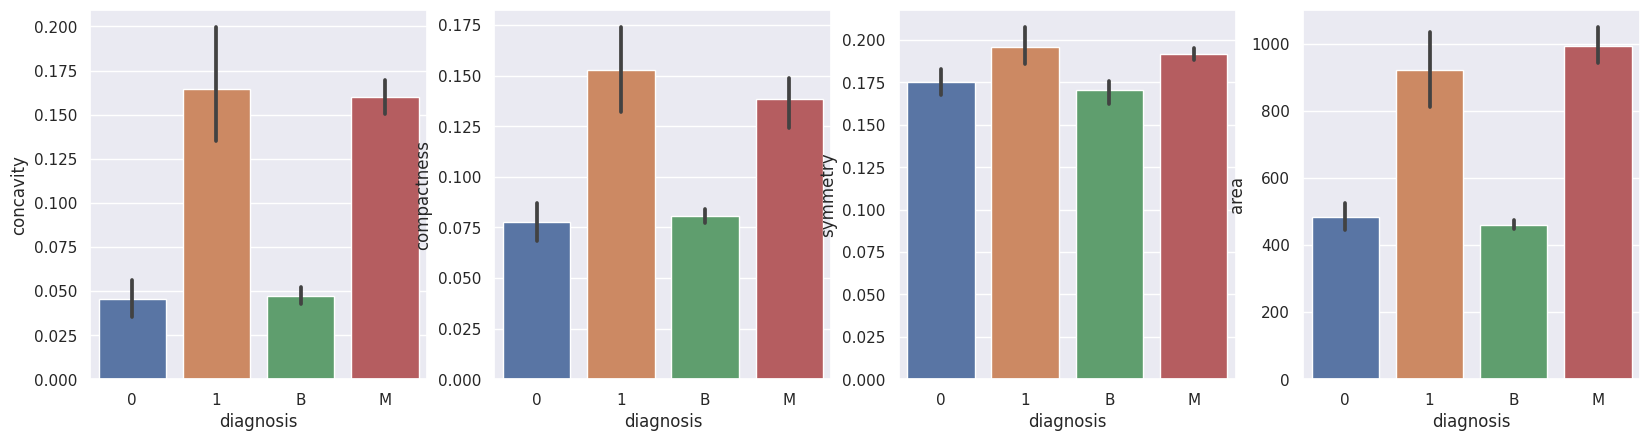

In [ ]:
fig, axs = plt.subplots(ncols=4)
fig.set_figwidth(20)

sb.barplot( x=LABEL, y="concavity", ax=axs[0], data=dataset )
sb.barplot( x=LABEL, y="compactness", ax=axs[1], data=dataset )
sb.barplot( x=LABEL, y="symmetry", ax=axs[2], data=dataset )
sb.barplot( x=LABEL, y="area", ax=axs[3], data=dataset )

From plots above, we can clearly see the mapping of 0s and 1s (0s and Bs have very similar values and same goes for 1s and Ms).

In [ ]:
dataset[LABEL] = dataset[LABEL].replace( { "1": "M", "0": "B" } )
print( attr_values( dataset, LABEL ) )

['B', 'M']
Categories (2, object): ['B', 'M']


Let's have a look if our dataset is balanced, hence if there is an equal number of malign and benign samples:

In [ ]:
def is_balanced( dataset: pd.DataFrame ) -> bool:
    malign = dataset.loc[ dataset[ LABEL ] == "M" ]
    benign = dataset.loc[ dataset[ LABEL ] == "B" ]

    assert len( malign ) + len( benign ) == len( dataset ) ## make sure they are complementary

    print( "malign:", len( malign ) )
    print( "benign:", len( benign ) )

    return len( malign ) == len( benign )

is_balanced( dataset )

malign: 232
benign: 393


False

We can see that there is quite an imbalance between the labels. We will deal with this after outliers handling.

## Handling outliers

Let's see if outliers cause any trouble in our dataset:

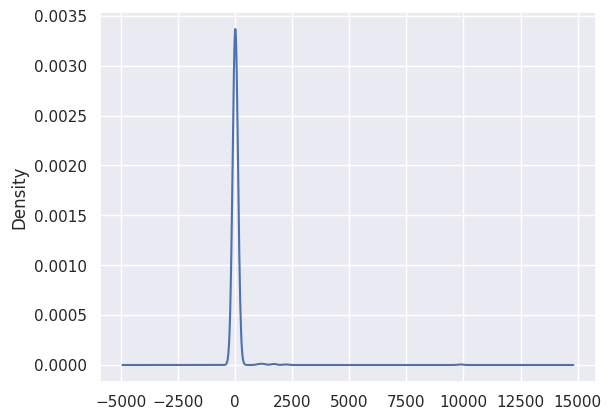

In [ ]:
def show_distribution( data: np.array ) -> None:
    data.plot(kind='kde')

show_distribution( dataset["radius"] )

Of course they do. Let's observe outliers in more features using boxplot

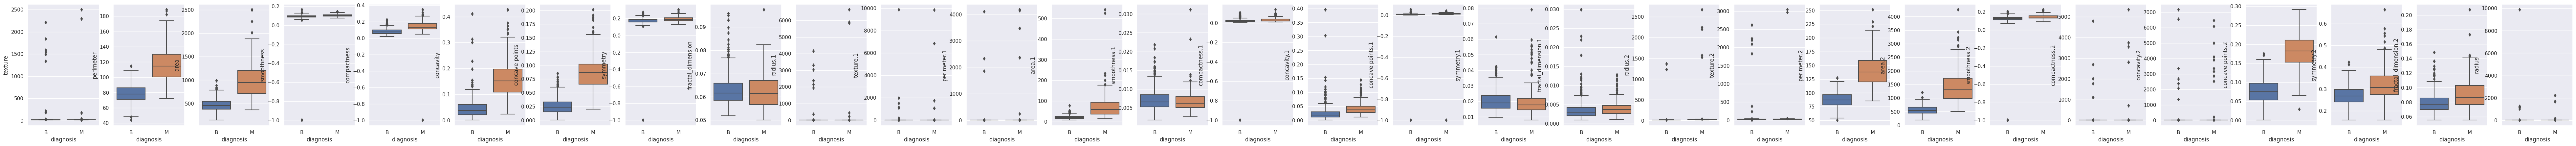

In [ ]:
def draw_boxplots( df: pd.DataFrame ) -> None:
    ncols = len( df.columns )
    fig, axs = plt.subplots(ncols=ncols)
    fig.set_figwidth(100)

    for i, col in enumerate( df.columns ):
        if col == LABEL:
            continue
        sb.boxplot(x=dataset[LABEL], y=df[col], ax=axs[i - 1])

draw_boxplots( without_label( dataset ) )

We can see that there are many outliers in majority of attributes There are many ways how to handle the outliers, however, we decided to remove them.

In [ ]:
def remove_outliers( df: pd.DataFrame ) -> pd.DataFrame:
    q1 = df.quantile( 0.25 )
    q3 = df.quantile( 0.75 )
    IQR = q3 - q1   ## inter quartile distance
    cleansed = df[ ~((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))) ]   ## everything except the records containing outliers
    return cleansed

without_outliers = remove_outliers( without_label( dataset ) )
without_outliers[ LABEL ] = dataset[ LABEL ]
dataset = without_outliers

After the outlier handling:

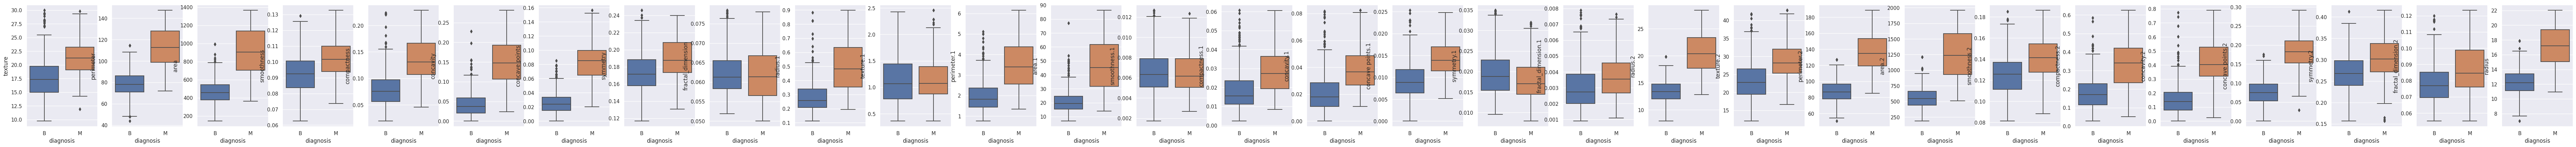

In [ ]:
draw_boxplots( without_label( dataset ) )

We've decided to use statistical approach to outlier detection, since we tried also other options, this one seemed to be the most consistent with our dataset.

## Handling empty values

Now, we are going to handle empty values, which we know are present in our dataset.

In [ ]:
def empty_count( df: pd.DataFrame, attr: str ) -> int:
    """
    Counts the number of empty values in dataframe 'df' in column 'attr'
    """
    return df[ attr ].isnull().sum()

print( f"Count of unfilled values in diagnosis column: {empty_count( dataset, LABEL )}" )

Count of unfilled values in diagnosis column: 0


Luckily, our label column is full, hence we do not need to impute any labels.

Let's have a closer look on the data types of our columns:

In [ ]:
dataset.dtypes

radius                  float64
texture                 float64
perimeter               float64
area                    float64
smoothness              float64
compactness             float64
concavity               float64
concave points          float64
symmetry                float64
fractal_dimension       float64
radius.1                float64
texture.1               float64
perimeter.1             float64
area.1                  float64
smoothness.1            float64
compactness.1           float64
concavity.1             float64
concave points.1        float64
symmetry.1              float64
fractal_dimension.1     float64
radius.2                float64
texture.2               float64
perimeter.2             float64
area.2                  float64
smoothness.2            float64
compactness.2           float64
concavity.2             float64
concave points.2        float64
symmetry.2              float64
fractal_dimension.2     float64
diagnosis              category
dtype: o

We can see that all attributes are **numerical** (except for diagnosis, which we know does not contain any empty value).

This observation allows us to replace empty values by mean of values in respective column (with respect to the class of the record). We are aware that there are multiple ways of how to impute empty values, but we decided to go with this technique.

In [ ]:
groupped = dataset.groupby( LABEL, as_index=False )   ## Dataset groupped by label

def fill_empty( df: pd.DataFrame, attr: str ) -> None:
    """
    Fills all empty values in 'df' in column 'attr' with mean of values
    with respect to the label of the record
    ( Assuming that the 'attr' is numerical attribute )
    """

    means = groupped[ attr ].mean()
    labels = means[ LABEL ]
    means = means.transpose()
    means.columns = labels
    means = means.drop( LABEL )

    ndf = pd.DataFrame()
    ndf[ "mean" ] = df.apply( lambda row: means[ row[ LABEL ] ], axis=1 )
    ndf[ LABEL ] = df[ LABEL ]
    ndf[ attr ] = df[ attr ]

    ndf[ attr ] = ndf.apply( lambda row: row[ "mean" ] if np.isnan( row[ attr ] ) else row[ attr ], axis = 1  )
    return ndf[ attr ]

def fill_dataset( df: pd.DataFrame ) -> pd.DataFrame:
    for col in dataset.columns:
        if col == LABEL:    ## diagnosis is fully filled as we demonstrated above
            continue
        if empty_count( dataset, col ) > 0:
            df[ col ] = fill_empty( dataset, col )

    return dataset


dataset = fill_dataset( dataset )

Let's check if we filled all empty values.

In [ ]:
for col in dataset.columns:
    print( empty_count( dataset, col ), end=" " )
print()

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


Great! Now our dataset is full.

## Dataset splitting

Until now, every step of the preprocessing has been done without any specific knowledge of the dataset. However, now we need to do preprocessing that depends on what our dataset contains. To avoid learning anything about the test subset of our dataset, we need to divide the whole dataset into train and test subset and continue exploring only the train one.

In [ ]:
SPLIT_RATIO = 4/5

labels = dataset[ LABEL ]
samples = without_label( dataset )

train_x, test_x, train_y, test_y = train_test_split( samples, labels, train_size=SPLIT_RATIO, random_state=42 )


assert SPLIT_RATIO - 0.01 <= len( train_x ) / ( len(train_x) + len( test_x ) ) <= SPLIT_RATIO + 0.1 ## Float arithmetics

## Correlations

Now let's see if our dataset contains any features that are correlated with other. We can remove those, as they don't introduce us to any new information.

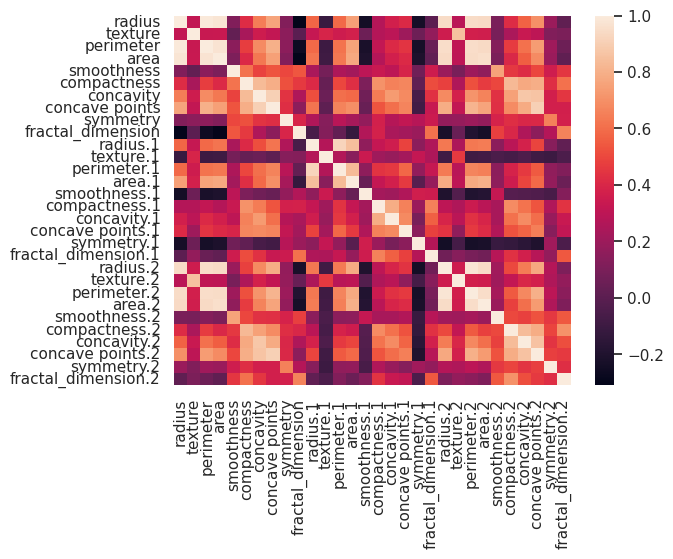

In [ ]:
def pair_correlations( df: pd.DataFrame ) -> None:
    corr_matrix = df.corr()
    sb.heatmap(corr_matrix,
        xticklabels=df.columns,
        yticklabels=df.columns)

pair_correlations( train_x )

We can see that radius, area and perimeter are strongly correlated (what a surprise), so we will only leave radius and remove area and perimeter. The same goes for concave points and concavity, so we will only leave concave points.

In [ ]:
to_drop = []
for col in dataset.columns:
    if "area" in col or "perimeter" in col or "concavity" in col:
        to_drop.append( col )

train_x = train_x.drop(to_drop, axis=1 )
test_x = test_x.drop(to_drop, axis=1 )

## Dataset standardization and resampling

In the section "Diagnosis handling" we noticed that there is an imbalance between the counts of malignant and benign samples. Since our dataset is relatively small, we decided to perform **oversampling** on our data (e.g. creating new malign samples based on certain rules).

For that purpose we will use the **SMOTE** algorithm. This algorithm helps us to prevent overfitting from just randomly replicating already existing malign samples. Internally, it uses the kNN algorithm so we've decided to scale our data with **StandardScaler** before using **SMOTE**.

In [ ]:
X = train_x
y = train_y
scaler = StandardScaler()
scaled_X = scaler.fit_transform( X )

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(scaled_X, y)

train_x = pd.DataFrame( X_resampled, columns=X.columns )
train_y = y_resampled.squeeze()
dataset = train_x.join( y_resampled )

In [ ]:
is_balanced( dataset )

malign: 311
benign: 311


True

Note that the new count of samples depends on original count of malign and benign samples in the training set which can vary in each run since train_test_split selects which samples to include randomly.

Now we can use the same standardization on our test dataset

In [ ]:
test_x_resampled = scaler.transform(test_x)
test_x = pd.DataFrame( test_x_resampled, columns=test_x.columns )

## Data visualization

Let's observe the distributions of the features:

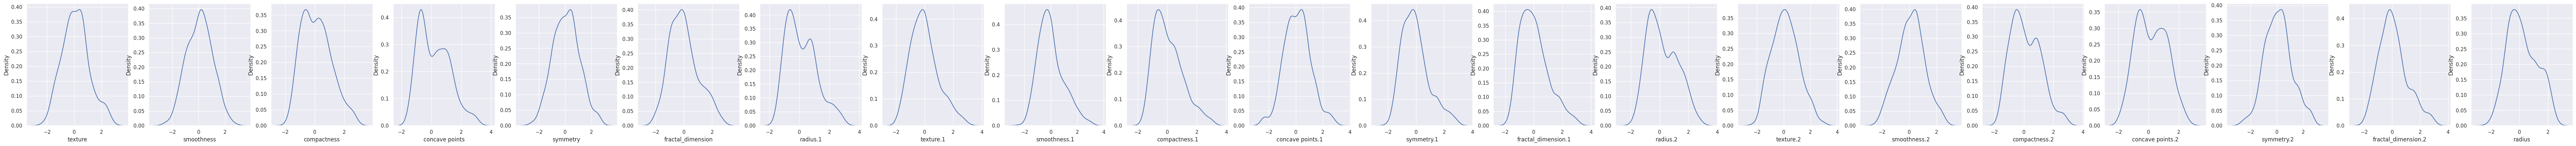

In [ ]:
def draw_distr( df: pd.DataFrame ) -> None:
    """
    Function to draw distribution of every attribute (except from the first one)
    """
    ncols = len( df.columns )
    fig, axs = plt.subplots(ncols=ncols)
    fig.set_figwidth(100)

    for i, col in enumerate( df.columns ):
      sb.kdeplot(df, x=col, ax=axs[i - 1])

draw_distr( train_x )

We can see that the majority of attributes have Gaussian-like distribution (although it might be skewed a bit).

# Model selection, explanation, training and interpretation

Our task is to predict type of the tumor based on its features, therefore we are solving a **classification** problem. We decided to train 3 distinct models and then compare their performance in order to select the best one.

## Feature selection

We already decided to leave some features out since they carry little to no aditional information. Now we are going to continue and try to find the important features with more sophisticated methods.

In [ ]:
def extract_selected(selector: SelectKBest, train_X: pd.DataFrame, train_y: pd.Series) -> list[ str ]:
    """
    Returns a numpy-like list of names of selected features from given selector
    and an array of input samples (X) and target values (y)
    """
    selector.fit_transform(train_X, train_y)
    indices = selector.get_support( indices=True )
    return dataset.columns[ indices ]

def find_k(model,
           train_X: pd.DataFrame,
           train_y: pd.Series,
           validation_X: pd.DataFrame,
           validation_y: pd.Series) -> int:
  """
  Iteratively compares accuracy of each k - number of features,
  returns k with highest accuracy on given model
  """
  accuracy = []
  for k in range(1, len(train_X.columns) + 1):
    pipeline = make_pipeline(
        SelectKBest(k=k),
        model
    )
    pipeline.fit(train_X, train_y)
    accuracy.append(pipeline.score(validation_X, validation_y))

  print(f"Max accuracy ({max(accuracy)}) achieved on validation set for k = {np.argmax(accuracy) + 1}")
  return np.argmax(accuracy) + 1


## Baseline model

We are going to create baseline model with **DummyClassifier**, which ignores input feature vector when predicting the output label. There are various strategies of how it can produce the output, however, we are going to use the strategy which always returns the most frequent label in training data.

In [ ]:
baseline = DummyClassifier( strategy="most_frequent" )
baseline.fit( train_x, train_y )

baseline.score( test_x, test_y )

0.656

In [ ]:
reset_y = test_y.reset_index( drop=True ) ## for the purpose of joining
reset_x = test_x.reset_index( drop=True )
test_set = reset_x.join( reset_y )

len( test_set.loc[ test_set[ LABEL ] == "B" ] ) / len( test_set )

0.656

The cell above explains the result of dummy classifier, since it classifies every sample as benign and our test set is unbalanced, the baseline classifier tells us the exact ratio of the imbalance.

However, this is not a very good result, let's create some better classifiers.

## Decision tree

**Model explanation**

A decision tree classifier is a type of machine learning algorithm used for classification tasks. It works by recursively partitioning the data into subsets based on the values of its features, and creating a tree-like model to make predictions based on the final subsets. Each internal node of the tree represents a feature and a threshold for that feature, and each leaf node represents a predicted class.

A decision tree is constructed recursively by selecting the best feature to split the data based on a criterion such as Information Gain or Gini impurity. The data is then split into subsets based on the values of the selected feature, and the process is repeated for each subset until a maximum depth of the tree is reached or minimum number of samples are in the subset.

Advantages of DT classifier:
*   Easy to interpret the decision-making process
*   Relatively insensitive to outliers
*   Can handle values of multiple types (categorical, numerical)

Disadvantages of DT classifier:
*   Biased towards categories with many possible values
*   Overfitting if tree is too complex
  - These disadvantages can be solved by using ensemble methods like random forest (later)

### Finding optimal parameters

For finding the optimal parameters of our classifier, we first need to further divide our training set into train and (validation) test sets.

In [ ]:
train_sub_x, test_sub_x, train_sub_y, test_sub_y = train_test_split(train_x, train_y, train_size=SPLIT_RATIO, random_state=42)

Now we can use GridSearch to find the best hyperparameters for our classifier.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

depth = [i for i in range(1,20)]
samples = [1,2,3,4,5,7,10,20,30,40,50,70]
criterion = ['gini', 'entropy']

scorer = make_scorer(f1_score, pos_label='M')
gs = GridSearchCV(DecisionTreeClassifier(), {'max_depth': depth, 'min_samples_leaf': samples, 'criterion': criterion}, cv=5, scoring=scorer)
gs.fit(train_x, train_y)
params = gs.best_params_

Now we can find the best features based on which our model will classify.

In [ ]:
optimized_dtc = DecisionTreeClassifier(max_depth=params['max_depth'],
                                       min_samples_leaf=params['min_samples_leaf'],
                                       criterion=params['criterion'],
                                       random_state=31)
X, y = train_sub_x, train_sub_y
k = find_k(optimized_dtc, X, y, test_sub_x, test_sub_y)

selector = SelectKBest(k=k)
dtc_selected_columns = extract_selected( selector, X, y )
print(dtc_selected_columns)

val_X = test_sub_x[ dtc_selected_columns ]
train_X = train_sub_x[ dtc_selected_columns ]

optimized_dtc.fit( train_X, y )

print(f1_score(optimized_dtc.predict(train_X), train_sub_y, average=None))
print(f1_score(optimized_dtc.predict(val_X), test_sub_y, average=None))

Max accuracy (0.968) achieved on validation set for k = 8
Index(['radius', 'compactness', 'concave points', 'radius.1', 'radius.2',
       'texture.2', 'compactness.2', 'concave points.2'],
      dtype='object')
[0.99386503 0.99405941]
[0.96969697 0.96610169]


### Model explanation

 Let's print our final decision tree

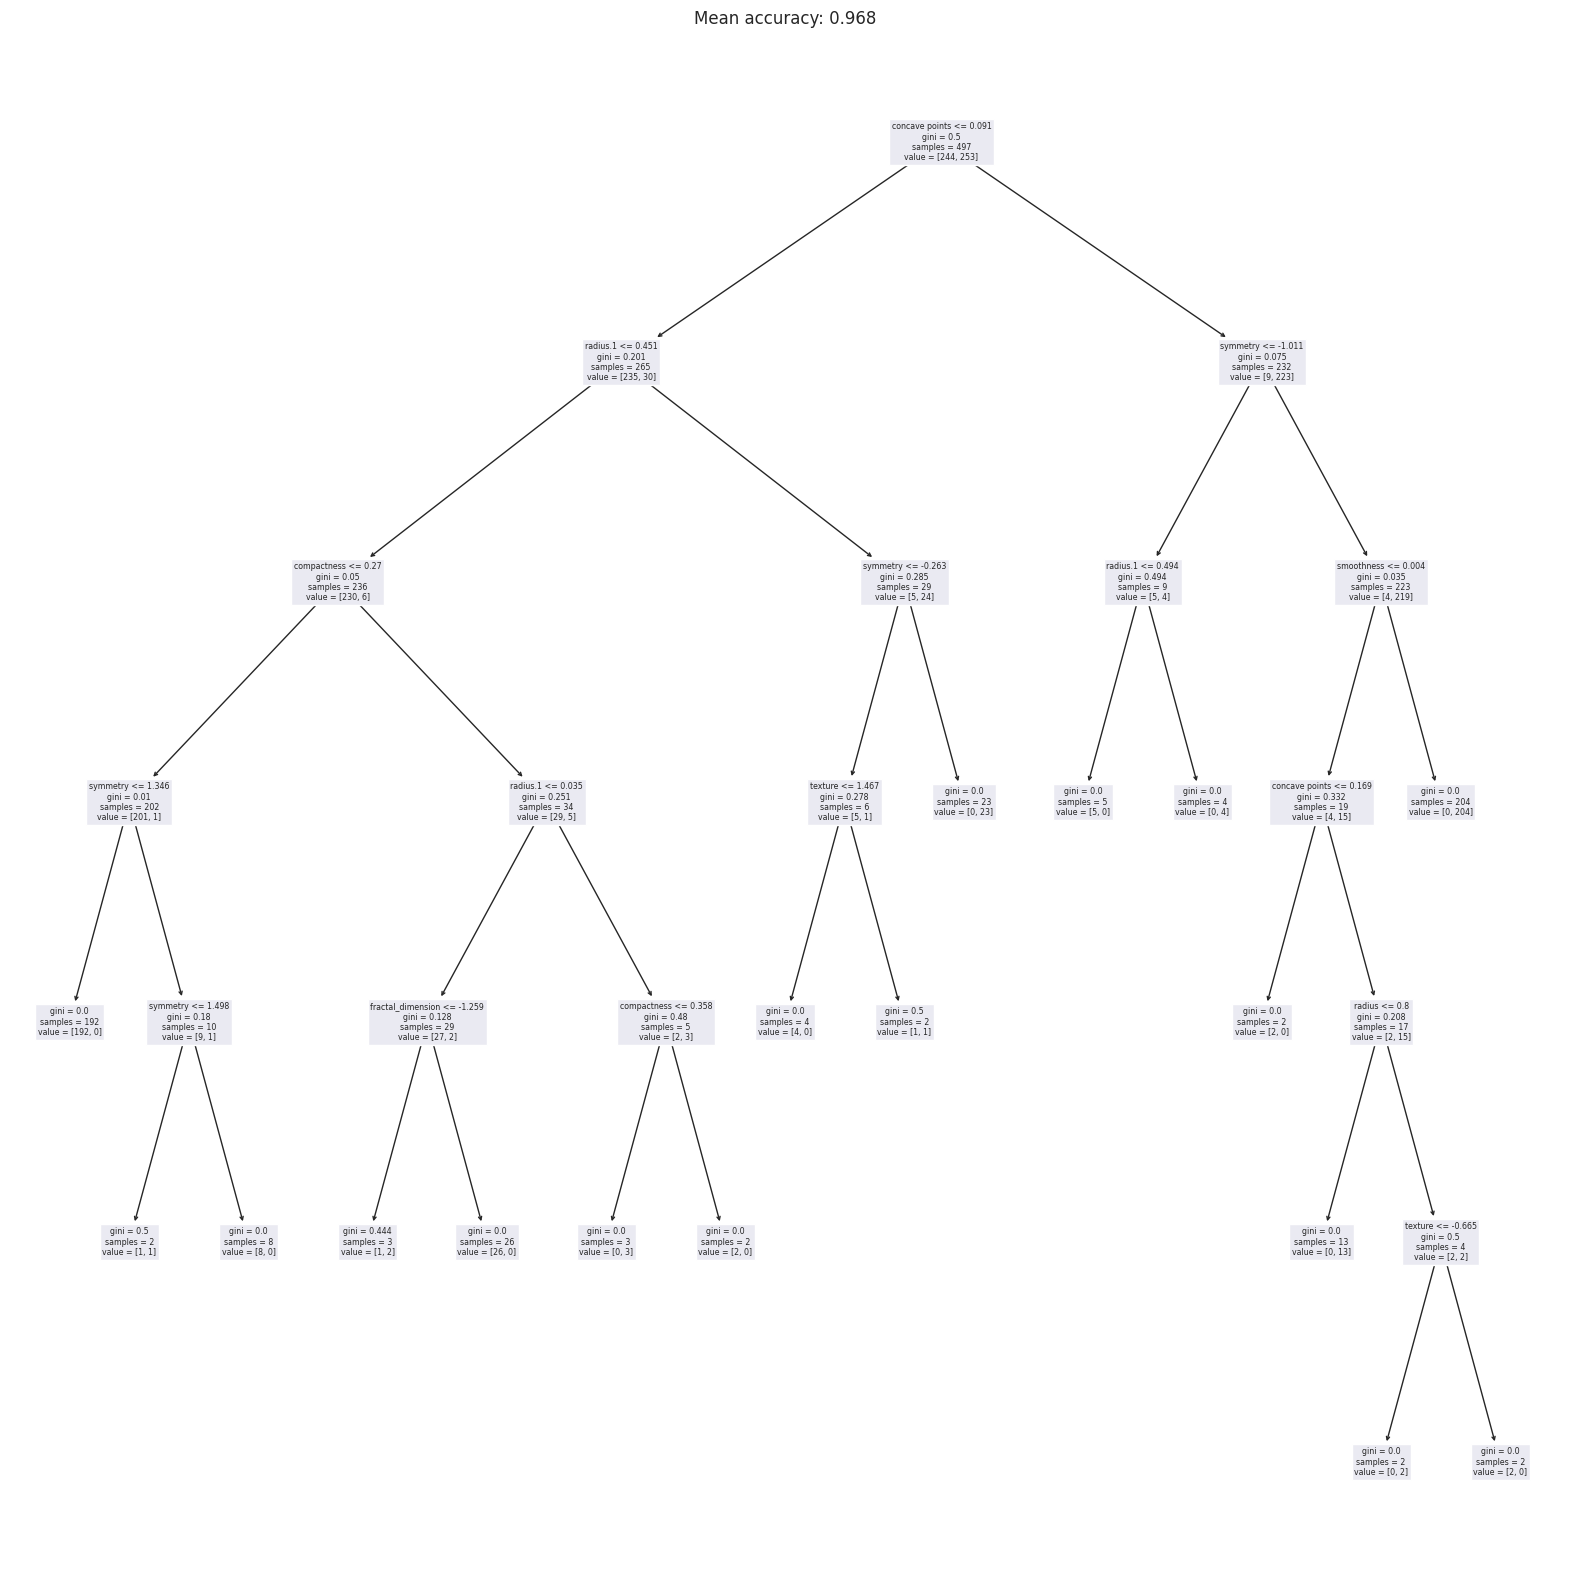

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(optimized_dtc, feature_names=train_x.columns)
plt.title("Mean accuracy: " + str(optimized_dtc.score(test_sub_x[dtc_selected_columns], test_sub_y)))
plt.show()

Our DT classified mainly based on concave points and radius. This is because:
- Concave points - malignant cells are often of irregular shape and create so called "concave points"
- Radius - bigger cells mean uncontrolled growth and malignancy


In [ ]:
importances = dict(zip( dataset.columns, optimized_dtc.feature_importances_))
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

for feature, importance in importances:
    print(feature, importance)

concave points 0.7372768077571762
radius.1 0.1635614544115134
symmetry 0.05141099098721245
compactness 0.014588415801809774
texture 0.010880570956318997
fractal_dimension 0.009754994650492888
smoothness 0.006286437975234531
radius 0.006240327460241774


<Axes: xlabel='diagnosis', ylabel='concave points'>

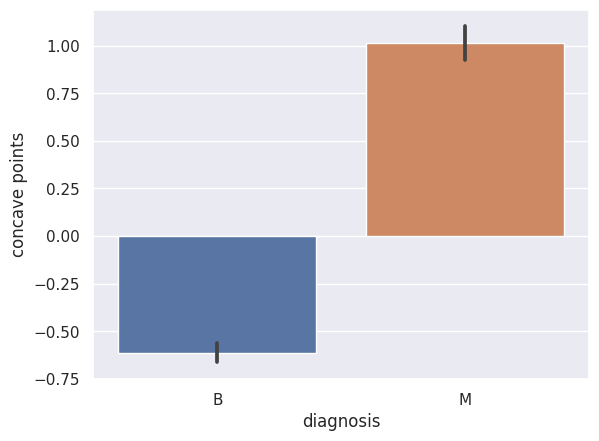

In [ ]:
sb.barplot( x=LABEL, y=importances[0][0], data=dataset )

<Axes: xlabel='diagnosis', ylabel='radius'>

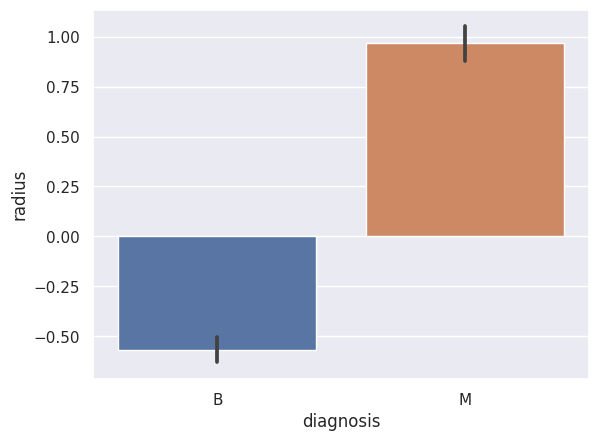

In [ ]:
sb.barplot( x=LABEL, y=importances[-1][0], data=dataset )

As we can see, even the least important feature in our decision tree is still quite helpful thanks to feature selection. However, in the end it's not very necessary :)

## K-nearest neighbours

### Model introduction

K-nearest neighbours is a supervised learning method used for classification and regression. Wanted class is determined to be the most common among $k$ nearest neighbours (i.e. we can call this "voting"). The nearest neighbours are determined by their distance (usually Euclidean distance).

The choice of the parameter $k$ is an important factor, as it can impact the effects of noise on the classification. For example, larger values reduce effect of the noise, but make boundaries between classes less distinct.

The advantages of k-NN are it's simplicity and it's characteristic property - lazy learning. That means it lacks any learning steps, k-NN requires only training data, from which it will make predictions.

Among disadvantages is k-NN's long prediction time, as every time we want to make a prediction, the k-NN searches the whole dataset, looking for the nearest neighbours. Even bigger issue is it's sensitivity to the structures inside the feature space because of it's reliance on distance.

### Parameter tuning

In order to train on our model, we need to determine the number of neighbours $k$ that will be used during our prediction. In other words, we aim to maximize the score. Sometimes this value is chosen to be $\sqrt{\text{number of features}}$. But as that is only a recommendation, we will have to do it on our own.
We will iterate through possible values of $k$ from 1 to the number of features. As candidate values will be chosen only odd numbers, as even values could cause a tie.

First, we will need to split the data and create validation set in order to avoid data leakage.

In [ ]:
train_sub_x, validation_sub_x, train_sub_y, validation_sub_y = train_test_split( train_x, train_y, train_size=SPLIT_RATIO, random_state=42 )

Now we will iterate and try to find the most accurate value for $k$ on our validation set.

In [ ]:
accuracy = []
for k in range(1, len(dataset.columns) + 1, 2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_sub_x, train_sub_y)
  accuracy.append(knn.score(validation_sub_x, validation_sub_y))
  print(k, accuracy[-1])
print(f"Max accuracy ({max(accuracy)}) achieved on validation set for k = {np.argmax(accuracy)*2 + 1}")


1 0.976
3 0.976
5 0.976
7 0.968
9 0.976
11 0.976
13 0.976
15 0.968
17 0.968
19 0.968
21 0.96
Max accuracy (0.976) achieved on validation set for k = 1


As we can see, highest accuracy achieved was 99% on $k = 1$. However we are not done yet. As this choice could be a sign of overifitting, we are going to run feature selection. Due to our rather spacious feature space (30 features), we can probably get better results by choosing only a subset of these features using SelectKBest method.

Now we have 2 variables - $k$, the number of neighbours and $m$, the subset of features. For this, we will employ a method called grid search. This method is used to search parameter space and choose combination of parameters with the lowest error.

Here we will try out different weight functions as well:

*   *uniform*, where points in neighbourhood are weighted the same
*   *distance*, where each point has a weight of 1/d, where d is the distance to the neighbor; this result in higher importance of close neighbours and lower importance of neighbours, that are far away



In [ ]:
parameters = {'knn__n_neighbors': range(1, len(train_sub_x.columns) + 1, 2),
              'kbest__k': range(1, len(train_sub_x.columns) + 1),
              'knn__weights': ('uniform', 'distance')}

kbest = SelectKBest()
knn = KNeighborsClassifier()

pipeline = Pipeline([('kbest', kbest), ('knn', knn)])
grid_search = GridSearchCV(pipeline, parameters, scoring='accuracy')
grid_search.fit(train_sub_x, train_sub_y)

knn_optimized = grid_search.best_estimator_.named_steps['knn']
print(grid_search.score(validation_sub_x, validation_sub_y))

0.992


As we can see, the grid search achieved accuracy lower then before. However, this will help with preventing overfitting on our dataset. Plus feature selection results in better explainability, as we can see what features did this model find important.

### Model explanation

In [ ]:
print(grid_search.best_params_)
knn_selected_columns = dataset.columns[ grid_search.best_estimator_.named_steps['kbest'].get_support(indices=True) ]
print(knn_selected_columns)

{'kbest__k': 10, 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Index(['radius', 'texture', 'compactness', 'concave points', 'radius.1',
       'concave points.1', 'radius.2', 'texture.2', 'compactness.2',
       'concave points.2'],
      dtype='object')


Let's look which parameters were deemed as best:


*   10 features (out of 30)
*   5 nearest neighbours
*   distance weight function

As I mentioned, many times the value of $k$ is chosen to be $\sqrt{\text{number of features}}$. This estimate was quite accurate.

Now we can look into which features earned the highest score while selecting using SelectKBest

In [ ]:
importances = dict(zip( dataset.columns, grid_search.best_estimator_.named_steps['kbest'].scores_))
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

for feature, importance in importances:
    print(feature, importance)

radius.2 926.4015775868638
concave points.2 870.6347536016923
concave points 765.4192052424091
radius 620.6223934727574
radius.1 269.00503651955177
compactness.2 264.38976327099346
compactness 258.43027206022725
texture.2 177.54956114919315
texture 159.2320477942292
concave points.1 151.2764766124118
smoothness.2 119.03924182267194
symmetry.2 75.51971607039381
smoothness 72.62714453340809
compactness.1 67.29514700345706
symmetry 59.77209632679937
fractal_dimension.2 55.39197919277733
symmetry.1 28.14116156971285
fractal_dimension.1 15.32511092926699
smoothness.1 0.5443498664005132
fractal_dimension 0.14458125490233123
texture.1 0.12703008896901222


Important is to realise why did this model choose these features:


*   Radius - bigger cells mean uncontrolled growth and malignancy
*   Concave points - malignant cells are many times of irregular shape and create so called "concave points"
*   Compactness - malignant cells are scattered and without clear borders
*   Texture - tumor cells look darker and their texture is more chaotic

The high score of error of radius shows, that diverse and uneven size of nuclei is a sign of malignancy.

## Random forest

**Model explanation**

**Random forest** classifier is one of so-called ensemble methods. These methods are called **ensemble** methods, because they're just basically putting other classifiers together and the result of the whole ensemble classifier is based on the "sub-results" of individual classifiers. In our case, random forest is basically a group of decision tree classifiers, where each tree is trained on different subset of attributes and data.

There are various approaches to the matter of how to pick samples from data and which attributes to select for individual classifiers. In the case of random forest, the features are selected randomly (that's why "random" forest), and for sample selection, we will use method of **bootstrapping** (samples are selected with replacement).

The resulting predicted class can be estimated by the **majority vote** of trees in the forest. Predictions of individual trees can be also weighted by their probabilty esimates.

### Finding optimal parameters

We are going to save some data for the validation.

In [ ]:
train_sub_x, validation_sub_x, train_sub_y, validation_sub_y = train_test_split( train_x, train_y, train_size=SPLIT_RATIO, random_state=42)

We are going to try to find optimal number of trees in our forest:

Since we already know the "optimal" features of individual trees (from DT classifier above), I am going to use them also on trees in random forest.

In [ ]:
n_trees = -1
best_score = -1

for n in range( 1, 110 ):
    forest = RandomForestClassifier(max_depth=params['max_depth'],
                                    min_samples_leaf=params['min_samples_leaf'],
                                    criterion=params['criterion'],
                                    n_estimators=n,
                                    random_state=42)
    forest.fit( train_sub_x, train_sub_y )

    score = forest.score( validation_sub_x, validation_sub_y )

    if score > best_score:
        print( "New best score:", score, "- number of trees:", n )
        best_score = score
        n_trees = n

New best score: 0.936 - number of trees: 1
New best score: 0.952 - number of trees: 2
New best score: 0.96 - number of trees: 4
New best score: 0.968 - number of trees: 7
New best score: 0.976 - number of trees: 8
New best score: 0.984 - number of trees: 15
New best score: 0.992 - number of trees: 22


### Model training and prediction

In [ ]:
forest = RandomForestClassifier(max_depth=params['max_depth'],
                                min_samples_leaf=params['min_samples_leaf'],
                                criterion=params['criterion'],
                                n_estimators=n_trees, random_state=42)

X, y = train_sub_x, train_sub_y
k = find_k(forest, X, y, validation_sub_x, validation_sub_y)

selector = SelectKBest(k=k)
forest_selected_columns = extract_selected( selector, X, y )

val_X = validation_sub_x[ forest_selected_columns ]
train_X = train_sub_x[ forest_selected_columns ]

forest.fit( train_X, y )
None # no print

Max accuracy (0.992) achieved on validation set for k = 15


### Model interpretation

Let's have a closer look on what our forest finds important:

In [ ]:
importances = dict( zip( forest.feature_names_in_, forest.feature_importances_ ) )
importances = sorted( importances.items(), key=lambda x: x[1] )

for feature, importance in importances:
    print( feature, importance )

smoothness 0.006635450873545259
symmetry 0.006877547835112283
compactness.1 0.007509693559849936
symmetry.2 0.007604137953751328
concave points.1 0.012961285999038783
smoothness.2 0.014227129067504962
texture.2 0.017447139404980792
compactness.2 0.02786063406737258
compactness 0.03093634594200181
texture 0.03307822826482366
radius.1 0.0631438670221486
radius 0.1289120234277249
concave points 0.1592326569144212
radius.2 0.19703603713589565
concave points.2 0.28653782253182825


We can see that the results differs from the results obtained from DT classifier.

Let's see if we can really tell our samples apart on the most important feature:

<Axes: xlabel='diagnosis', ylabel='concave points.2'>

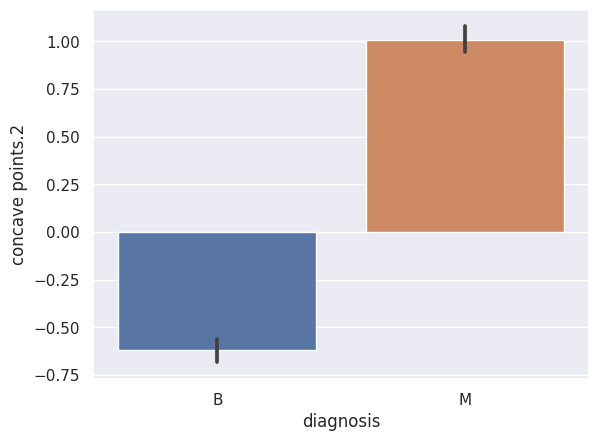

In [ ]:
sb.barplot( x=LABEL, y=importances[-1][0], data=dataset )

We can see that this attribute indeed splits our dataset quite well.

Let's also plot the least important attribute:

<Axes: xlabel='diagnosis', ylabel='smoothness'>

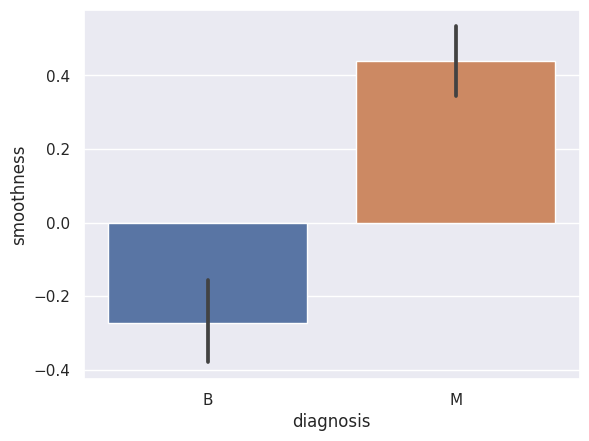

In [ ]:
sb.barplot( x=LABEL, y=importances[0][0], data=dataset )

# Model evaluation

Now, that we have all 3 models trained, we are going to compare them and try to select the best one. As our evaluation measure, we will use **F1 score** (depends on precision and recall) and **accuracy**. For better visualization, we will also plot the **confusion matrix** for each model's predictions:

Random forest:
f1 0.963855421686747
accuracy 0.976


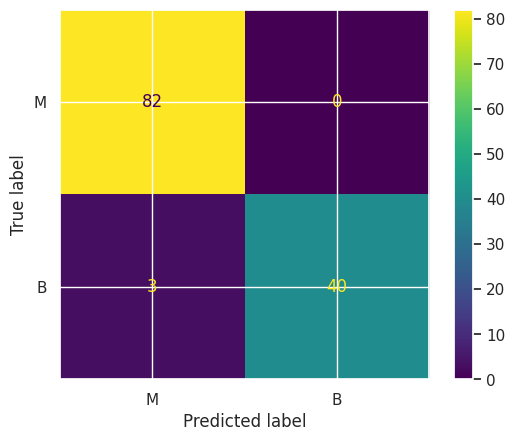

---
Decision tree:
f1 0.9534883720930233
accuracy 0.968


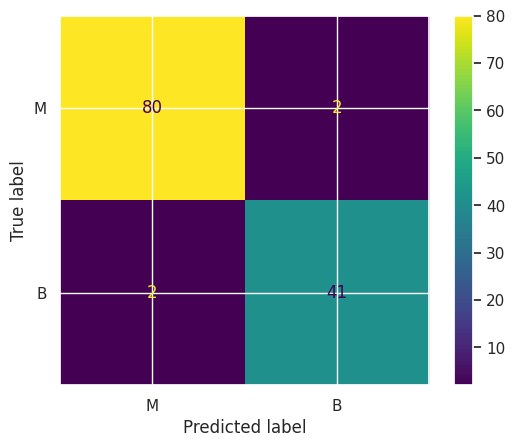

---
Knn:
f1 0.942528735632184
accuracy 0.96


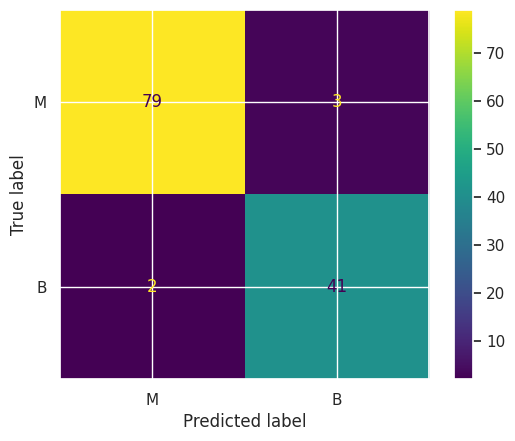

---


In [ ]:
def evaluate(model,
             selected_features: list[ str ],
             test_x: pd.DataFrame,
             test_y: pd.Series) -> dict[ str, Union[int, np.array] ]:
    """
    Function which takes model and test data and returns scoring of the model
    """
    f1 = f1_score( test_y, model.predict( test_x[ selected_features ] ), pos_label="M" )
    accuracy = accuracy_score( test_y, model.predict( test_x[ selected_features ] ) )
    confusion = confusion_matrix( test_y, model.predict( test_x[ selected_features ] ) )
    return { "f1": f1, "accuracy": accuracy, "confusion_matrix": confusion }

def show_stats( evaluated: dict[ str, Union[int, np.array] ] ) -> None:
    for k, v in evaluated.items():
        if k == "confusion_matrix":
            continue
        print( k, v )

    confusion = evaluated[ "confusion_matrix" ]
    disp = ConfusionMatrixDisplay( confusion_matrix=confusion, display_labels=["M", "B"] )
    disp.plot()
    plt.show()

print("Random forest:")
show_stats(evaluate( forest, forest_selected_columns, test_x, test_y ) )
print("---")

print("Decision tree:")
show_stats(evaluate( optimized_dtc, dtc_selected_columns, test_x, test_y ) )
print("---")

print("Knn:")
show_stats(evaluate( knn_optimized, knn_selected_columns, test_x, test_y) )
print("---")

We can see that all of our models are doing much better than the baseline model. From our data we can also observe that Random forest is doing a bit better than the other two, let's see if this difference is statistically significant (we will do this by performing **t-test**):

## Performing t-test

Firstly, we are going to need to divide our test set into n folds and measure accuracies of each model on each fold:

In [ ]:
names = {forest: "RF", optimized_dtc: "DT", knn_optimized: "KNN"}

def get_fold_acc(models,
                 k_folds: int,
                 models_features: list[ list[ str ] ],
                 samples: pd.DataFrame,
                 labels: pd.Series ) -> pd.DataFrame:

    folder = KFold( n_splits=k_folds )

    data = np.empty( shape=( k_folds, len(models) ) )
    data.fill(1)

    for i, (model, selected_features) in enumerate(zip(models, models_features)):
        for j, (fold_index, _) in enumerate(folder.split(samples)):
            X = samples.iloc[ fold_index ]
            y = labels.iloc[ fold_index ]
            accuracy = accuracy_score( y, model.predict( X[ selected_features ] ) )
            data[ j, i ] = accuracy

    return pd.DataFrame(data=data, columns=[ names[model] for model in models ])

models = [ forest, optimized_dtc, knn_optimized ]
model_features = [ forest_selected_columns, dtc_selected_columns, knn_selected_columns ]

accuracies = get_fold_acc( models, 8, model_features, test_x, test_y )
accuracies

,RF,DT,KNN
0,0.972477,0.963303,0.954128
1,0.972477,0.963303,0.954128
2,0.981651,0.972477,0.963303
3,0.972477,0.963303,0.963303
4,0.981651,0.963303,0.963303
5,0.972727,0.972727,0.954545
6,0.981818,0.972727,0.963636
7,0.972727,0.972727,0.963636


Since we want to compare them pair-wise, we are going to create differences of accuracies of each pair on given fold:

In [ ]:
seen = set()

diff_accuracies = pd.DataFrame()

for col1 in accuracies.columns:
    for col2 in accuracies.columns:
        if col1 == col2 or col2 in seen:
            continue
        diff_accuracies[ f"{col1} - {col2}" ] = accuracies[col1] - accuracies[col2]

    seen.add( col1 )

diff_accuracies

,RF - DT,RF - KNN,DT - KNN
0,0.009174,0.018349,0.009174
1,0.009174,0.018349,0.009174
2,0.009174,0.018349,0.009174
3,0.009174,0.009174,0.000000
4,0.018349,0.018349,0.000000
5,0.000000,0.018182,0.018182
6,0.009091,0.018182,0.009091
7,0.000000,0.009091,0.009091


Now we are going to compute t-test on each pair and obtain the **p-value**:

Tested null hypothesis is: Difference in accuracies is 0.

In [ ]:
results = {}

for col in diff_accuracies:
    results[ col ] = ttest_1samp(diff_accuracies[col], popmean=0)

results

{'RF - DT': TtestResult(statistic=3.8582024842355174, pvalue=0.006225962983277822, df=7),
 'RF - KNN': TtestResult(statistic=10.67241296340251, pvalue=1.3909210927326051e-05, df=7),
 'DT - KNN': TtestResult(statistic=3.872187739092055, pvalue=0.006114372861469449, df=7)}

Based on computed p-value, we can say (significance level is 0.05):
- There is a statistically significant difference between accuracies of random forest and decision tree (p-value < 0.05)
- There is a statistically significant difference between accuracies of random forest and knn (p-value < 0.05)
- There is a statistically significant difference between accuracies of decision tree and knn (p-value < 0.05)

Since the accuracies of random forest are higher and statistically significantly different than the accuracies of other two, we can say that the random forest is the optimal choice out of those three. On the other hand, kNN seems to be the least optimal choice.

NOTE: We could also use function ttest_rel and did not need to compute the accuracy differences, however we decided to go for more "demonstrative" way.